# Population analysis of Asia and North America from 1955-2020
## Group 07 - Members

| **No**  | **Student ID** | **Full Name**         |
| ------- | -------------- | ----------------------|
| 1       | 20127452       | Hồ Đăng Cao           |
| 2       | 20127449       | Trần Quốc Bảo         |
| 3       | 20127476	   | Đỗ Đức Duy            |
| 4       | 20127327       | Ngô Hữu Nhật Thanh    |

---

## Import the necessary libraries

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

---

## Crawling population data from web
The dataset used for population analysising is collected from links in [Danso.org](https://danso.org/the-gioi/)

To crawling data, we go through 2 stages:

`stage 1:` Get list of links containing data of each country in area.

`stage 2:` Browse through each site in links list to crawling data.


### Stage 1: Get list of links containing df of each country in area.

- Get chrome driver to browse in `Chrome`

In [2]:
browser = webdriver.Chrome(executable_path="../chromedriver_win32/chromedriver.exe")
# browser = webdriver.Chrome()

C:\Users\ACER\AppData\Local\Temp\ipykernel_6080\2240451907.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(executable_path="../chromedriver_win32/chromedriver.exe")


- Build function to get `html doc` from website

In [3]:
def get_html_from_link(link):
    browser.get(link)
    browser.implicitly_wait(20)
    browser.minimize_window()

    return BeautifulSoup(browser.page_source, "html.parser")

- Access `the-gioi page` to get list of `countries' raw links` (in html)

In [4]:
html_text = get_html_from_link("https://danso.org/the-gioi/")
links = html_text.find_all('h3')[:56]
links[0]

<h3 class="entry-title"><a href="https://danso.org/bermuda/">Bermuda</a></h3>

- Get `links` from `raw links`

In [5]:
links = list(map(lambda link: re.findall("<a href=\"([\w.:/-]+)\">",str(link))[0], links))
links[0]

'https://danso.org/bermuda/'

- Get `countries' names` from `links`

In [6]:
country_name = list(map(lambda x: re.findall('/([\w-]+)/',str(x))[0], links))
country_name[0]

'bermuda'

### Stage 2: Browse through each site in links list to crawling df.

At each country, there are 13 attributes, include: `Year, Population, %Change, Change, Migrate, Average age, Birth rate, Density, %urban resident, Urban resident, %world population, world population and rank`. Or only 10 attributes, without: `Average age, Birth rate, Density`.

In this project, we only care about: `Year, Population, Change, Migrate, Urban_resident`.

There are 2 main function in this stage:

- `get_table` function: Get list of data line from html text

| **No**  | **Description**| **Content**           |
| ------- | -------------- | ----------------------|
| 1       | Input          | `html_text` (str): raw html text of website           |
|         |                | `country_name`: country's name of the website         |
| ------- | -------------- | --------------------------------------------------------------------------------------------------------------|
| 2       | Output  	   | `a_table` (list of list): each element is a list containing df in each year (size: 18x6).            |
| ------- | -------------- | --------------------------------------------------------------------------------------------------------------|
| 3       | Steps          | get raw df rows (till contain html code) by `find_all` function.    |
|         |                | get data from raw rows by `re` module.    |
|         |                | remove empty rows (containing header rows).    |
|         |                | get column containing `5 attributes` that we are interested in and add `country name` as a new attribute.    |

In [7]:
def get_table(html_text, country_name):
    rows = html_text.find_all('tr',{'role':'row'})[1:20]
    a_table = list(map(lambda line: re.findall('>([\d,-N.A]+)<',str(line)), rows))
    a_table = list(filter(lambda line: len(line) > 0, a_table))
    a_table = list(map(lambda line: [country_name] + line[:2] + line[3:5] + [line[-4]], a_table))
    return a_table

- `write_to_file` function: write data table of all countries to file. 

| **No**  | **Description**| **Content**           |
| ------- | -------------- | ----------------------|
| 1       | Input          | `table` (list of list): each element is a list containing data in each year each country [size: (18 years x 56 countries) rows x 6 attributes].|
| ------- | -------------- | --------------------------------------------------------------------------------------------------------------|
| 2       | Steps          | write name of 6 attributes to file.    |
|         |                | cast each element to `str` and get data (remove brackets).    |
|         |                | replace string `', '` with `\t` and add `\n` character.    |
|         |                | write each line of table to file.    |

In [8]:
def write_to_file(table):
    with open("data.tsv",'w') as f:
        f.write("Country\tYear\tPopulation\tChange\tMigrate\tUrban_resident\n")
        table = list(map(lambda line: str(line)[2:-2].replace("\', \'", '\t')+'\n',table))
        for line in table:
            f.write(line)

Now, it's time to combine:

- Get html text from each country site.

- Get data tables from these sites and add to table.

- Finally, write the table to file.

In [9]:
table = []
for i in range(len(links)):
    html_text = get_html_from_link(links[i])
    table += get_table(html_text, country_name[i])
write_to_file(table)

In [10]:
# Close the Chrome browser
browser.quit()

---

### Read data from tsv file into Pandas dataframe
- read file and split into lines.

- split the first line by tab character to get attributes.

- put remain lines into Pandas dataframe, then split them by tab character.

- Finally, split each rows into 6 columns.

In [2]:
with open("data.tsv") as f:
    rows = f.read().split('\n')
    keys = rows[0].split('\t')
    df = pd.DataFrame([rows[1:-1]]).apply(lambda line: line.str.split('\t'))
    df = pd.DataFrame(df.iloc[0].to_list(), columns=keys)
    
df.head()

,Country,Year,Population,Change,Migrate,Urban_resident
0,bermuda,2019,62.506,-250,1.250,60.833
1,bermuda,2018,62.756,-293,1.255,61.070
2,bermuda,2017,63.049,-313,1.261,61.349
3,bermuda,2016,63.362,-330,1.267,61.666
4,bermuda,2015,63.692,-339,1.274,62.003


---

## Data explorations

### How many rows and columns does the data have ?

In [26]:
Num_rows,Num_cols=df.shape
print(f"The data have {Num_rows} rowls")
print(f"The data have {Num_cols} columns")

The data have 1008 rowls
The data have 6 columns


### Are there any dulicate row in the data?

In [4]:
have_dulicate_rows = df.duplicated().sum()
print("Yes") if have_dulicate_rows else print('No')

No


### What do the  columns in the data mean?

- **Country** : Name of the country
- **Year**: Display year
- **Population**: The population of each country
- **Change**: The number of population changes
- **Migration**: The number of migratory population including immigration and emigration
- **Urban_resident**: Number of population living in urban areas

### What data type does each column currently have? 

In [5]:
df.dtypes

Country           object
Year              object
Population        object
Change            object
Migrate           object
Urban_resident    object
dtype: object

**What does columns that have object dtype mean?**

All columns in data have datatype of object.If the datatype of a column in dataframe is object, the datatype of elements in that column can be different from each other.so we will list the data types present in each column

In [6]:
def check_dtype(s):
    dtypes = set()
    s.apply(lambda x : dtypes.add(type(x)))
    return dtypes
print('List type in Country column:', end='')
print(check_dtype(df['Country']))

print('List type in Year column:', end='')
print(check_dtype(df['Year']))

print('List type in Population column:', end='')
print(check_dtype(df['Population']))

print('List type in Change column:', end='')
print(check_dtype(df['Change']))

print('List type in Migrate column:', end='')
print(check_dtype(df['Migrate']))

print('List type in Urban_resident column:', end='')
print(check_dtype(df['Urban_resident']))

List type in Country column:{<class 'str'>}
List type in Year column:{<class 'str'>}
List type in Population column:{<class 'str'>}
List type in Change column:{<class 'str'>}
List type in Migrate column:{<class 'str'>}
List type in Urban_resident column:{<class 'str'>}


**Issues that need to be reprocessed:**


-   The column "Country" has str data type. 
-   The  columns " Year" , "Population" , "Change"," Migrate":  data type current is string , we wil  change from str data type to int 
-    The Urban_resident column has an inappropriate value (N.A). Since in those countries there is 100% urban population, we will assign N.A to the population of that country for the year. Finally convert the values in the column to int data type.

## Preprocessing

### Convert dtype of "Urban_resident" columns to int

-    The columns 'Urban_resident' has an inappropriate value (N.A.).Values like N.A. then at that time the urban population is also the population of that country. So we change the value for N.A. Then convert to int type

In [7]:
def check_Population(x):
    if x['Urban_resident']=="N.A.":
        return x['Population']
    else:
        return x['Urban_resident']
df['Urban_resident']=df[['Urban_resident' ,'Population']].apply(check_Population,axis=1)
df.Urban_resident=df.Urban_resident.apply(lambda x: x.replace(".",''))
df.Urban_resident=df.Urban_resident.apply(lambda x: int(x))

### Convert dtype of" Year" , "Population" , "Change" and " Migrate" columns to int

In [8]:
df.Year = df.Year.apply(lambda x : int(x))
df.Population=df.Population.apply(lambda x: x.replace(".",''))
df.Population=df.Population.apply(lambda x: int(x))
df.Change=df.Change.apply(lambda x: x.replace(".",''))
df.Change=df.Change.apply(lambda x: int(x))
df.Migrate=df.Migrate.apply(lambda x: x.replace(".",''))
df.Migrate=df.Migrate.apply(lambda x: int(x))

Current datatype

In [9]:
df.dtypes

Country           object
Year               int64
Population         int64
Change             int64
Migrate            int64
Urban_resident     int64
dtype: object

## Data explorations (continue)

### Data distribution of columns ('Population' , 'Change' , 'Migrate' , 'Urban_resident')

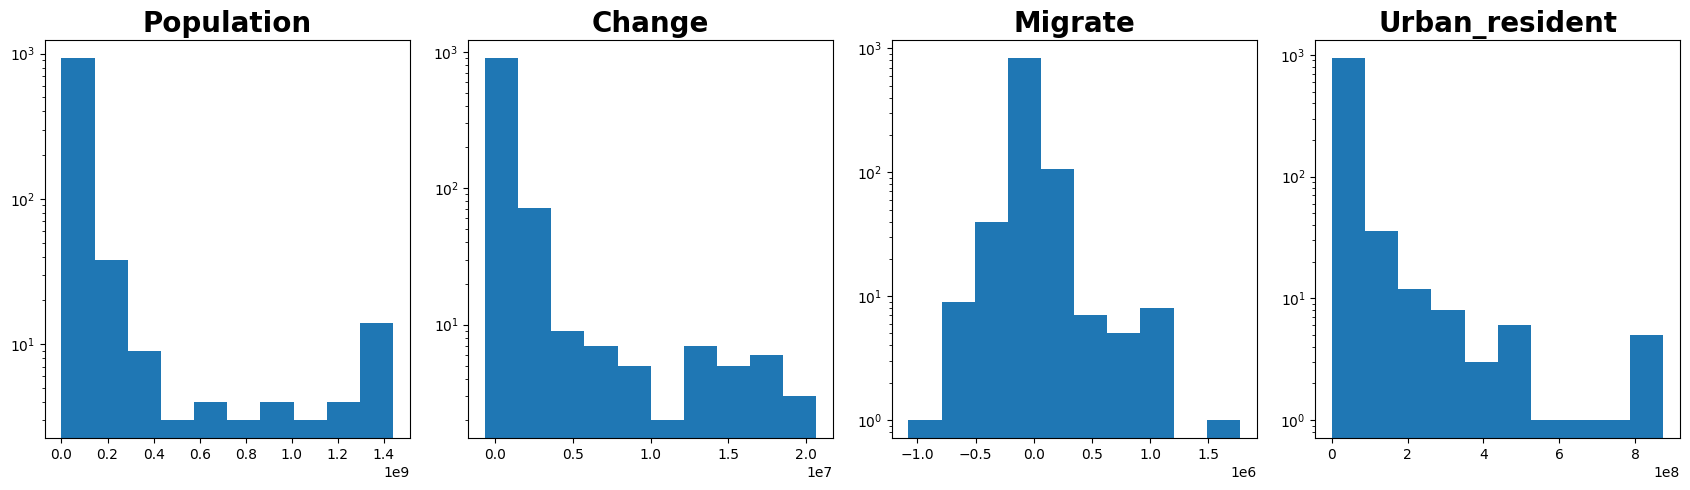

In [10]:
Arrat=df.drop("Country",axis=1)
Arrat=Arrat.drop("Year",axis=1)
fig , axs=plt.subplots(1, len(Arrat.columns), figsize=(17,5))
for i , ax in enumerate(axs.flat):
    ax.hist(Arrat.iloc[:,i] )
    ax.set_title(Arrat.columns[i],fontsize=20,fontweight='bold')
    ax.semilogy()
plt.tight_layout()

-   `Comment`
    -  Data distribution table of columns Population , Change , Migrare , Urban_resident
    - In the Migrate column , there are negative and positive values . Negative value indicates the migrant countries. Positive value indicates the immigrant countries
    - In the Change column, there are positive and negative values. A negative value indicates that the population of that country has decreased compared to the population of the previous data update. A positive value indicates an increase in the population of that country compared to the population of the previous data update
    - So negative signs are just formal marks to indicate a certain meaning without affecting the value

### Data distribution of columns ('Year')

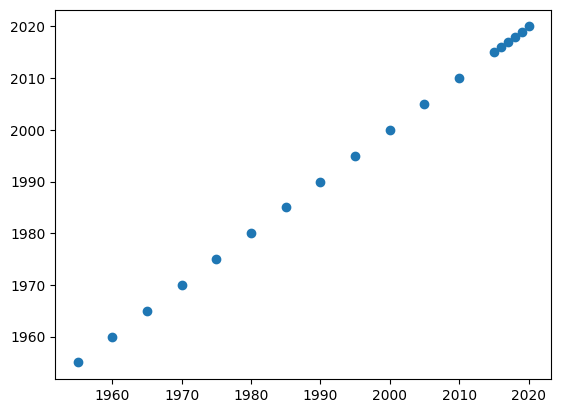

In [11]:
year_arr=df['Year'].sort_values().unique()
plt.scatter(year_arr,year_arr )
plt.show()

-  `Comment` 
   - In the Year column, there are years from 1995 to 2020 and the distribution is not uniform
   - From 1955 to 2015, Each data update is 5 years apart. And from 2015 to 2020 they are only 1 year apart.

### Data distribution of columns ('Country')

#### We collect data for 56 countries in Asia and North America

-   `Countries in Asia`

In [12]:
Country_arr=df['Country'].unique()
Asia={}
Asia['Asia']=Country_arr[5:]
Asia=pd.DataFrame(Asia)
Asia=Asia.T
Asia.head()


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
Asia,a-rap-xe-ut,afghanistan,an-do,armenia,azerbaijan,bahrain,bangladesh,bhutan,brunei,cac-tieu-vuong-quoc-a-rap-thong-nhat,...,syria,tajikistan,thai-lan,tho-nhi-ky,trieu-tien,trung-quoc,turkmenistan,uzbekistan,viet-nam,yemen


- `Countries in North America`

In [13]:
North_America={}
North_America['North America']=Country_arr[:5]
North_America=pd.DataFrame(North_America)
North_America=North_America.T
North_America.head()


,0,1,2,3,4
North America,bermuda,canada,greenland,hoa-ky,saint-pierre-va-miquelon


### For each column with numeric data types, how are the values distributed?

- The datetime columns will be added to the numeric group .There appear to be 5 columns in the numeric group right now: 'Year' , 'Population','Change','Migrate','Urban_resident'
- I will compute the percentage of missing values (from 0 to 100), the minimum and maximum for each numeric column .The results are saved to the dataframe `Nume_col_data`

In [14]:
Nume_col_data={}

#Year  
temp={}
Year_miss=(df['Year'].isnull().sum()/len(df['Year']))*100
Year_max=df['Year'].max()
Year_min=df['Year'].min()
temp['Missing_value']=Year_miss
temp['Max']=Year_max
temp['Min']=Year_min
Nume_col_data['Year']=temp

#Population
temp={}
Population_miss=(df['Population'].isnull().sum()/len(df['Population']))*100
Population_max=df['Population'].max()
Population_min=df['Population'].min()
temp['Missing_value']=Population_miss
temp['Max']=Population_max
temp['Min']=Population_min
Nume_col_data['Population']=temp

#Change
temp={}
Change_miss=(df['Change'].isnull().sum()/len(df['Change']))*100
Change_max=df['Change'].max()
Change_min=df['Change'].min()
temp['Missing_value']=abs(Change_miss)
temp['Max']=abs(Change_max)
temp['Min']=abs(Change_min)
Nume_col_data['Change']=temp

#Migrate
temp={}
Migrate_miss=(df['Migrate'].isnull().sum()/len(df['Migrate']))*100
Migrate_max=df['Migrate'].max()
Migrate_min=df['Migrate'].min()
temp['Missing_value']=abs(Migrate_miss)
temp['Max']=abs(Migrate_max)
temp['Min']=abs(Migrate_min)
Nume_col_data['Migrate']=temp

#Urban_resident
temp={}
Urban_resident_miss=(df['Urban_resident'].isnull().sum()/len(df['Urban_resident']))*100
Urban_resident_max=df['Urban_resident'].max()
Urban_resident_min=df['Urban_resident'].min()
temp['Missing_value']=Urban_resident_miss
temp['Max']=Urban_resident_max
temp['Min']=Urban_resident_min
Nume_col_data['Urban_resident']=temp
Nume_col_data=pd.DataFrame(Nume_col_data)
Nume_col_data=Nume_col_data.astype('int')
Nume_col_data.head()

,Year,Population,Change,Migrate,Urban_resident
Missing_value,0,0,0,0,0
Max,2020,1439323776,20676485,1771991,875075919
Min,1955,4755,673024,1077397,3942


`Comment:` Data cleaning and processing is quite good so 100% no data is missing.Ready to answer questions

## Ask a meaningful question

There are five number of questions that can be answered with data after exploring it and better understanding it:
-   Which are immigrant countries and migrant countries
-   Migration rate of countries in the region over the year => Find top 3 immigrant/migrant countries
-   Average population growth rate of countries from 1955 to 2020 year
-   The most/least populous country in area in each year
-   Calculate average population of countries in a period

### Which are immigrant countries and migrant countries

- `Migrant countries`

In [15]:
Migrant_countries={}
Immigrant_countries={}
Migrant_countries['Country']=[]
Migrant_countries['Migrate']=[]
Immigrant_countries['Country']=[]
Immigrant_countries['Migrate']=[]
Immigrant_countries
def Check_Migrant(x):
    if x['Migrate'] < 0:
       Migrant_countries['Country'].append(x['Country'])
       Migrant_countries['Migrate'].append(x['Migrate'])
    elif x['Migrate'] >0:
        Immigrant_countries['Country'].append(x['Country'])
        Immigrant_countries['Migrate'].append(x['Migrate'])
Temp=df[['Country','Migrate']]
Temp=Temp.groupby('Country').mean().reset_index()
Temp.apply(Check_Migrant,axis=1)
Migrant_countries=pd.DataFrame(Migrant_countries)
KQ=Migrant_countries[['Country']].T
KQ.head()


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Country,afghanistan,an-do,armenia,azerbaijan,bangladesh,bhutan,campuchia,dong-timo,georgia,indonesia,...,philippines,sri-lanka,syria,tajikistan,trieu-tien,trung-quoc,turkmenistan,uzbekistan,viet-nam,yemen


-   `Immigrant countries`

In [16]:
Immigrant_countries=pd.DataFrame(Immigrant_countries)
KQ=Immigrant_countries[['Country']].T
KQ.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
Country,a-rap-xe-ut,bahrain,bermuda,brunei,cac-tieu-vuong-quoc-a-rap-thong-nhat,canada,cong-hoa-sip,dai-loan,han-quoc,hoa-ky,...,ma-cao,malaysia,maldives,nhat-ban,oman,qatar,saint-pierre-va-miquelon,singapore,thai-lan,tho-nhi-ky


### Migration rate of countries in the region over the year => Find top 5 immigrant/migrant countries

-   Top 5 Migrant countries

In [17]:
def TinhToan(x):
    return (x['Migrate']/x['Population'])*1000
def abs_x(x):
    return abs(x)
Top5_Migrant=df[['Country' ,'Population' ,'Migrate']].loc[df['Country'].isin(Migrant_countries['Country'].unique())]
Top5_Migrant['Migrate']=Top5_Migrant['Migrate'].apply(abs_x)
Top5_Migrant['Tyle']=Top5_Migrant[['Population','Migrate']].apply(TinhToan,axis=1)
Top5_Migrant=Top5_Migrant[['Country','Tyle']].groupby('Country').mean().sort_values('Tyle').reset_index()
Top5_Migrant['Tyle']=Top5_Migrant['Tyle'].apply(lambda x: abs(x))
Top5_Migrant= Top5_Migrant.tail(5)
Top5_Migrant=Top5_Migrant.groupby('Country').sum()
Top5_Migrant.head()

,Tyle
Country,
afghanistan,9.261272
armenia,6.718504
kazakhstan,6.189694
palestine,8.719181
syria,11.626894


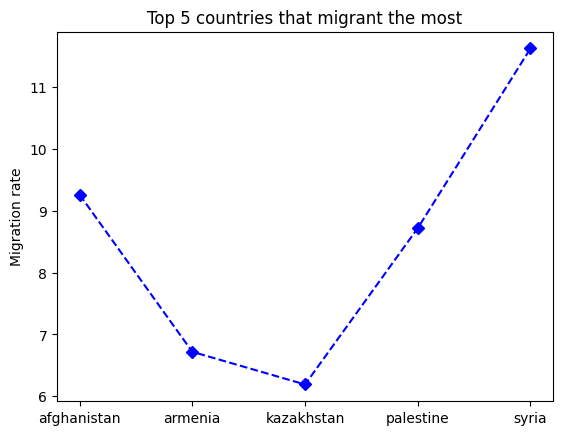

In [18]:
plt.plot(Top5_Migrant,'bD--')
plt.ylabel('Migration rate')
plt.title('Top 5 countries that migrant the most')
plt.show()

-  Top 5 Immigrant countries

In [19]:
def TinhToan(x):
    return (x['Migrate']/x['Population'])*1000
Top5_immigrant=df[['Country' ,'Population' ,'Migrate']].loc[df['Country'].isin(Immigrant_countries['Country'].unique())]
Top5_immigrant['Tyle']=Top5_immigrant[['Population','Migrate']].apply(TinhToan,axis=1)
Top5_immigrant=Top5_immigrant[['Country','Tyle']].groupby('Country').mean().sort_values('Tyle',ascending=False).reset_index()
Top5_immigrant= Top5_immigrant.head(5)
Top5_immigrant=Top5_immigrant.groupby('Country').sum().sort_values('Tyle',ascending=False)
Top5_immigrant.head()

,Tyle
Country,
qatar,30.756632
cac-tieu-vuong-quoc-a-rap-thong-nhat,30.201535
bermuda,20.000191
bahrain,16.801409
kuwait,14.424274


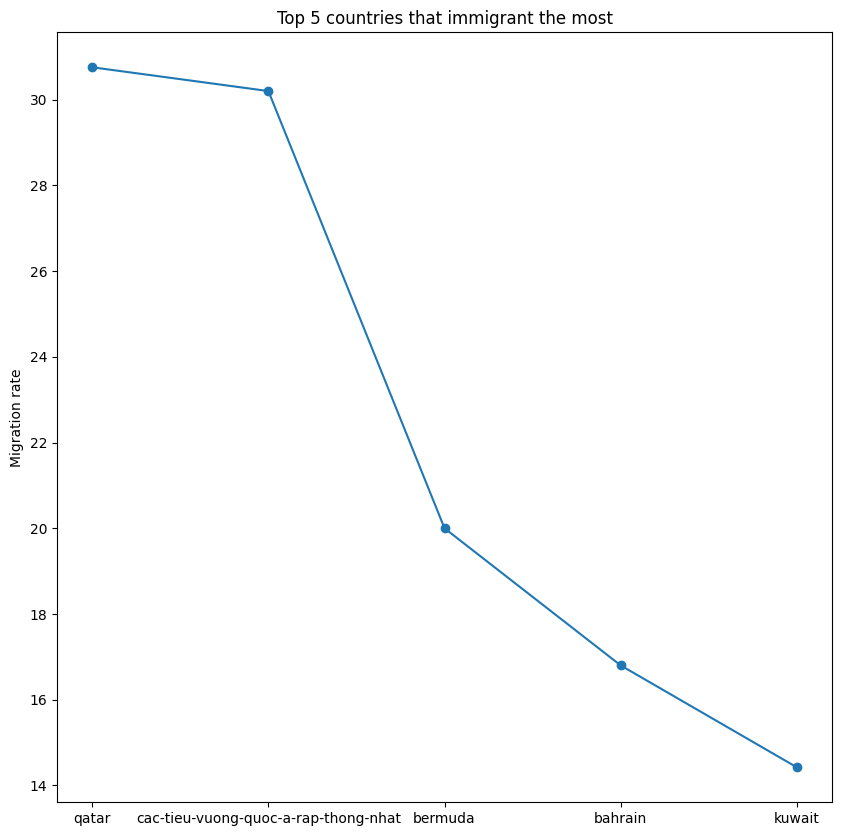

In [20]:
plt.figure(figsize=(10,10))
plt.plot(Top5_immigrant,marker='o')
plt.ylabel('Migration rate')
plt.title('Top 5 countries that immigrant the most')
plt.show()

### Average population growth rate of countries from 1955 to 2020 year

In [21]:
NameCountry_arr=df['Country'].unique()
Aver_growt_data={}
Aver_growt_data['Country']=[]
Aver_growt_data['Average annual population growth rate']=[]
for i in NameCountry_arr:
    KQ=[]
    Aver_growt_rate=df[['Year','Country','Population']][df['Country']==i].sort_values('Year',ascending=False)
    size_arr=len(Aver_growt_rate)
    Aver_growt_rate.index=range(1,size_arr+1)
    Toal=Aver_growt_rate['Population'][1] / Aver_growt_rate['Population'][18]
    Toal=Toal**(1/(Aver_growt_rate['Year'][1]-Aver_growt_rate['Year'][18]))
    Toal=Toal-1
    Aver_growt_data['Country'].append(i)
    Aver_growt_data['Average annual population growth rate'].append(Toal)
Aver_growt_data=pd.DataFrame(Aver_growt_data) 
Aver_growt_data=Aver_growt_data.sort_values('Average annual population growth rate',ascending=False)
Aver_growt_data=Aver_growt_data.head(5).groupby('Country').sum()

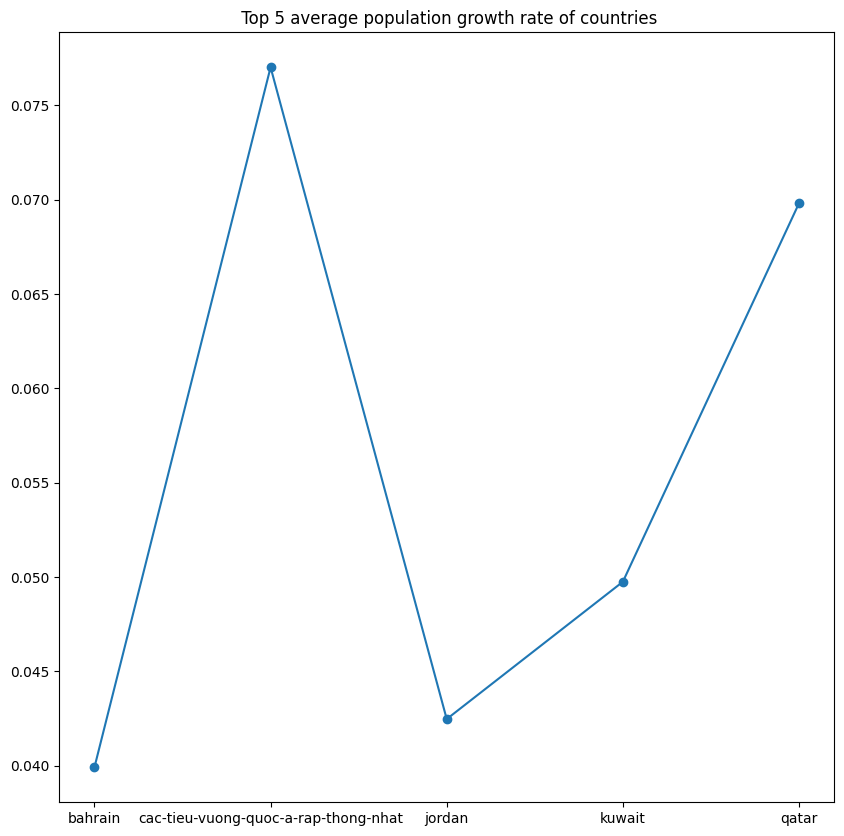

In [22]:
plt.figure(figsize=(10,10))
plt.plot(Aver_growt_data,marker='o')
plt.title(' Top 5 average population growth rate of countries')
plt.show()

### The most/least populous country in area in each year

In [23]:
Temp=df[['Year','Country','Population']]
Temp=Temp.pivot(index='Year',columns='Country',values='Population')
Populous_most_least={}
Populous_most_least['Most populous']=Temp.idxmax(axis=1).values
Populous_most_least[' Min populous']=Temp.idxmin(axis=1).values
Populous_most_least=pd.DataFrame(Populous_most_least,index=Temp.index)
Populous_most_least

,Most populous,Min populous
Year,,
1955,trung-quoc,saint-pierre-va-miquelon
1960,trung-quoc,saint-pierre-va-miquelon
1965,trung-quoc,saint-pierre-va-miquelon
1970,trung-quoc,saint-pierre-va-miquelon
1975,trung-quoc,saint-pierre-va-miquelon
1980,trung-quoc,saint-pierre-va-miquelon
1985,trung-quoc,saint-pierre-va-miquelon
1990,trung-quoc,saint-pierre-va-miquelon
1995,trung-quoc,saint-pierre-va-miquelon


### Calculate average population of countries in a period

In [24]:
Ave_Population=df[["Country","Population"]]
Ave_Population= Ave_Population.rename(columns={'Population': 'Average population'})
Ave_Population=Ave_Population.groupby("Country").mean()
Ave_Population=Ave_Population.sort_values('Average population',ascending=False)
Ave_Population=Ave_Population.head(5)
Ave_Population

,Average population
Country,
trung-quoc,1.154278e+09
an-do,9.649575e+08
hoa-ky,2.675474e+08
indonesia,1.931995e+08
pakistan,1.336526e+08


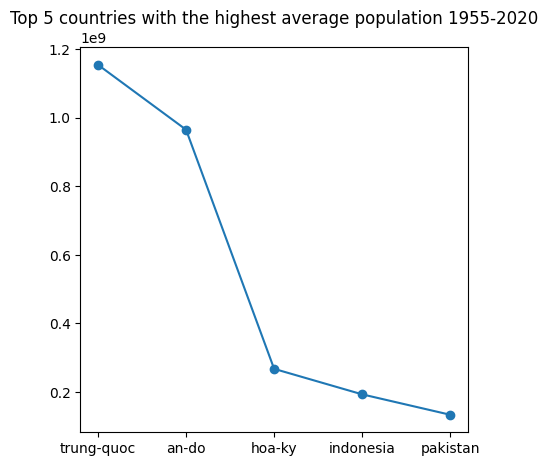

In [25]:
plt.figure(figsize=(5,5))
plt.plot(Ave_Population,marker='o')
plt.title('Top 5 countries with the highest average population 1955-2020')
plt.show()

`Comment:` Looking at the map, we see that the two countries, India and China, have a very large average population (1995-2020) and are far behind the rest of the countries.